ББМО-02-22 Исаев А.М. ЛР3

Установим tf-keras-vis

In [1]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 619.1 kB/s eta 0:00:00


In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


Для работы необходимо загрузить модель - импортируем VGG16, модель, нейросеть для выделения признаков изображений

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

После успешной загрузки VGG16 загрузим кастомные изображения из датасета IMAGENET, в другом случае существует вероятность некорректного результата выполенния работы. Стоит отметить что keras-vis позволяет обрабатывать сразу несколько изображений.

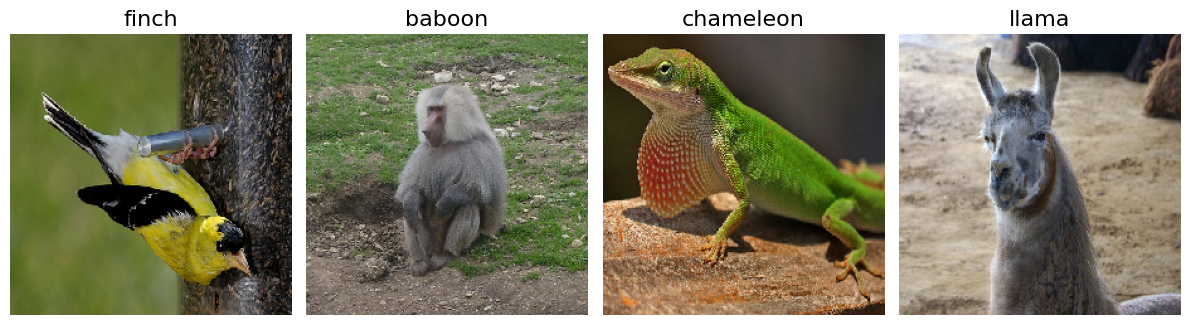

In [4]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

image_titles = ['finch', 'baboon', 'chameleon', 'llama']

# импорт изображения с размером 224х224 и помещаем их в np.array массивы
img1 = load_img('finch.JPEG', target_size=(224, 224))
img2 = load_img('baboon.JPEG', target_size=(224, 224))
img3 = load_img('chameleon.JPEG', target_size=(224, 224))
img4 = load_img('llama.JPEG', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Подготавливаем входы для VGG16 и отображаем
X = preprocess_input(images)


f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# используем keras_vis
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()


def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [6]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([14, 372, 47, 355])

def score_function(output):
    return (output[0][14], output[1][372], output[2][47], output[3][355])

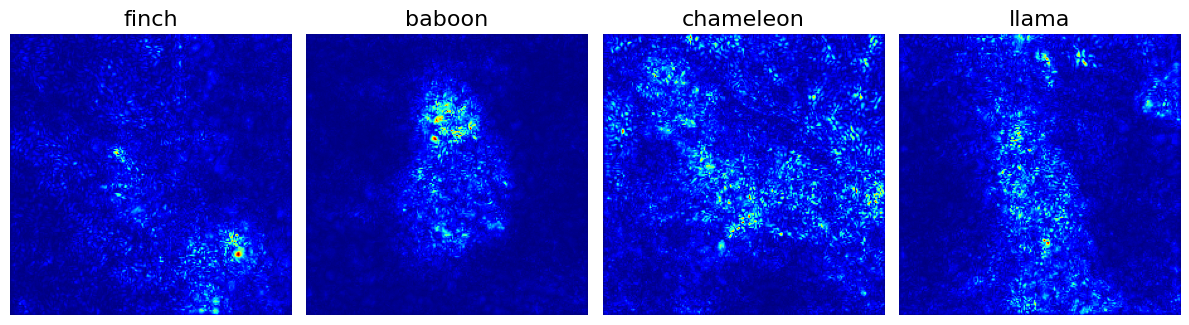

CPU times: user 6.59 s, sys: 1.23 s, total: 7.82 s
Wall time: 9.22 s


In [7]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# Объект внимания и карта
saliency = Saliency(model, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, X)


f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

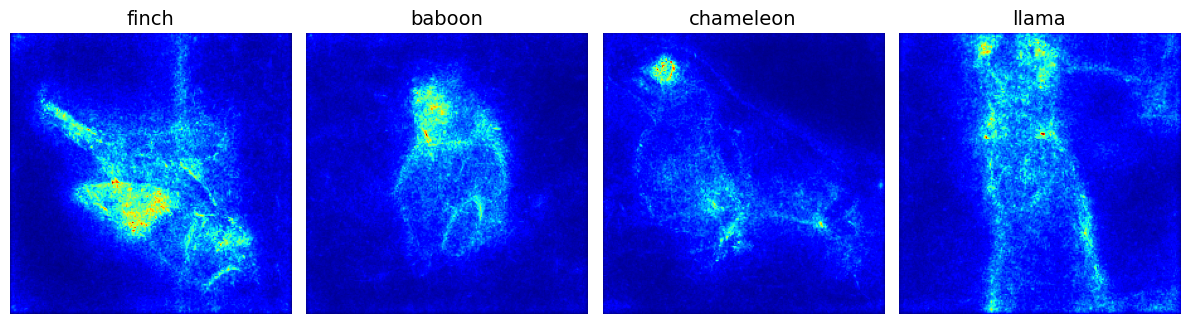

CPU times: user 2.1 s, sys: 268 ms, total: 2.37 s
Wall time: 3.53 s


In [8]:
%%time

saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)


f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

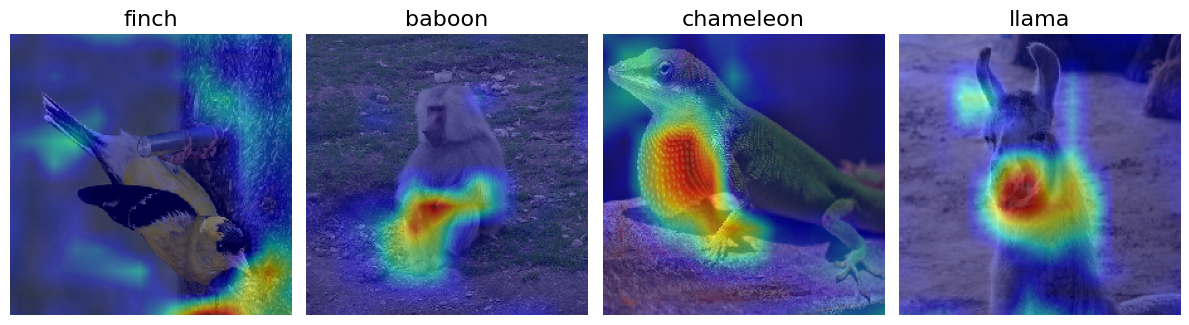

CPU times: user 1.5 s, sys: 838 ms, total: 2.33 s
Wall time: 2.23 s


In [9]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

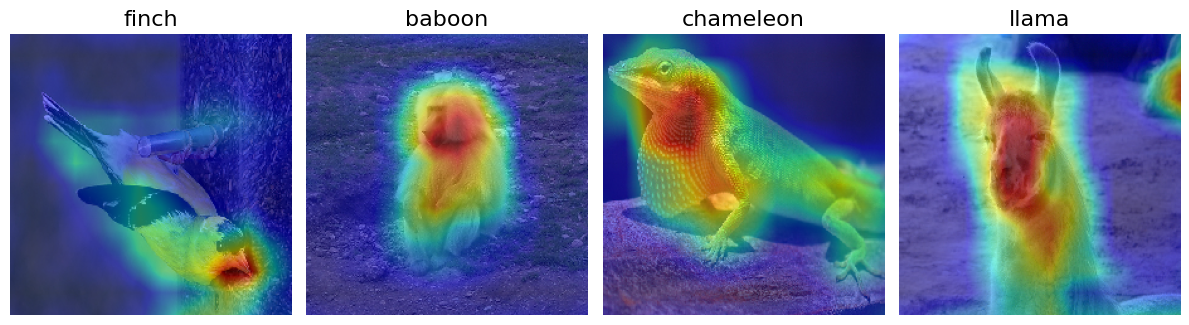

CPU times: user 2.07 s, sys: 816 ms, total: 2.88 s
Wall time: 2.84 s


In [10]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus


gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)


cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()